# Basic Tutorial
To run any model in BATMODS-lite, you will need to construct a `Simulation` and `Experiment`. All `Simulation` classes are constructed using a `.yaml` file that contains a description of the parameters. The easiest way to find out how to build a `.yaml` input for the model you wish to run is to get a template from `bmlite.templates`. When calling the `templates` function, just pass the name of the model subpackage (case insensitive) to get a list of available templates.

In [1]:
import numpy as np
import bmlite as bm

bm.templates('spm')

spm templates:
  - [0] graphite_nmc532


To actually print a templates, pass a second input as the name or index from the list of available files. Below we will take a look at the `graphite_nmc532` file.

In [2]:
bm.templates('spm', 0)

graphite_nmc532.yaml
battery:
    cap:        1.89e-2               # Nominal capacity                       [A*h]
    temp:       303.15                # Temperature                              [K]
    area:       1.4e-3                # Cell area                              [m^2]

electrolyte:
    Li_0:       1.2                   # Initial Li+ conc.                 [kmol/m^3]

anode:
    Nr:         30                    # Number of r discretizations              [-]
    thick:      44.0e-6               # Thickness                                [m]
    R_s:        4.0e-6                # Secondary particle radius                [m]
    eps_s:      0.6                   # Solid-phase volume frac.                 [-]
    eps_el:     0.4                   # Electrolyte volume frac.                 [-]
    eps_CBD:    0.0569272237          # Carbon-binder-domain volume frac.        [-]
    alpha_a:    0.5                   # Anodic charge transfer coeff.            [-]
    alpha_c: 

The output above shows a full list of parameters that must be specified to build a `SPM.Simulation` instance. By default, if you do not provide an input to `SPM.Simulation`, this is the file that will be loaded. Running with this exact set of parameters won't be particularly useful to most users. Therefore, you will have to construct your own input file using this one as a template. It is recommended to copy this file into your preferred text editor and to make changes as needed. Be careful to input parameter values in the units that are provided.

After making a new file, you can initialize a model instance with your own parameters by passing the absolute or relative path to your file as an input to the `Simulation` class. For example,

```python
sim = bm.SPM.Simulation('newfile.yaml')
```

Note that the `.yaml` extension is optional.

You can learn more about any of of the SPM parameters by looking at the `bm.SPM.domains` module. You will also want to look at the ``bm.materials`` package to view all of the available material classes. Specifying an electrode active material that is not available in ``bm.materials`` will result in an error.

## Experiments
Once your `Simulation` instance is initialized, you will want to construct an `Experiment` to run. The `Experiment` class is not model specific. It is accessed from the base-level of `bmlite` and will work with any `Simulation` class, regaurdless of which model subpackage your are using.

Building an `Experiment` is similar to programming a cycler. You first initialize an instance and then add steps to it. Steps require a mode, value, time span, and optional arguments. There are a variety of options that you can take advantage of within any given step, as discussed below.

The `tspan` input can be given as a tuple or an array. When specified as a tuple, the types are particularly important. The first element will always be the maximum timespan (in seconds) for the present step. The second input should either be a integer or float. When an integer is given, `np.linspace(0, t_max, Nt)` is used to construct the times at which the solution will be saved by using `tspan = (t_max: float, Nt: int)`. Alternatively, if you provide a float, the value is interpreted as a constant $\delta t$. So, in the second example below, we plan to save the solution every 10 seconds. If the $\delta t$ does not evenly fit into `t_max`, then the last time step may differ from the one specified. Lastly, for complete control over your timespan, you can pass an array. The only requirements of the array are that the first element is zero, it has a length of at least two, and all values are monotonically increasing.

In [3]:
# Uses np.linspace(0, 1350, 150) to construct tspan
expr = bm.Experiment()
expr.add_step('current_C', 2., (1350., 150))

# Constructs tspan from 0 to 1350 in increments of 10 seconds
expr = bm.Experiment()
expr.add_step('current_C', 2., (1350., 10.))

# Builds a ustom tspan, but makes sure to follow the above restrictions
tspan = np.hstack([0, np.logspace(-1, 3)])     

expr = bm.Experiment()
expr.add_step('current_C', 2., tspan)

In addition to the timespan options, the `Experiment` class controls important solver options. In some experimental steps, it may be more important to have a tight tolerance, whereas a loose tolerance may be sufficient for other steps. To see a full list of solver options, check out the `bm.IDASolver` class. In cases where you want to modify the solver options to not use a default value across all steps in an experiment, you should pass the solver options during the original initialization. Alternatively, you can specify solver options at a step by step level. If you specify a global experiment option and also provide that same option for any given step, then the value specified in the step will take precedence. For example, the experiments below ensure the maximum integration step `max_step=10` for all steps, sets the absolute tolerance of the second step as `atol=1e-9`, and overwrites of the `max_step` option in the third step to be `1` instead of `10`.

In [4]:
expr = bm.Experiment(max_step=10.)
expr.add_step('current_C', 2., (1350., 150))
expr.add_step('current_C', 0., (1350., 150), atol=1e-9)
expr.add_step('current_C', -2., (1350., 150), max_step=1.)

An easy way to check that you've built your experiment correctly is to print the steps to the console. Note that although the steps above were referred to as first, second, and third, BATMODS-lite actually refers to each step by its index starting with zero. This is consistent with the Python language as a whole and should hopefully feel natural to most users. Check the codeblock and its output below to see how to print the steps in an easy to read format.

In [5]:
expr.print_steps()


Step 0
--------------------
mode    : 'current'
value   : 2.0
units   : 'C'
tspan   : array([   0.        ,    9.06040268, ..., 1340.93959732, 1350.        ])
limits  : None
options : {'max_step': 10.0}

Step 1
--------------------
mode    : 'current'
value   : 0.0
units   : 'C'
tspan   : array([   0.        ,    9.06040268, ..., 1340.93959732, 1350.        ])
limits  : None
options : {'max_step': 10.0, 'atol': 1e-09}

Step 2
--------------------
mode    : 'current'
value   : -2.0
units   : 'C'
tspan   : array([   0.        ,    9.06040268, ..., 1340.93959732, 1350.        ])
limits  : None
options : {'max_step': 1.0}


## Limits
Multi-step experiments in the lab are typically programmed by using limits or events. For example, discharge a battery until 3V is reached. This capability is also available in the `Experiments` class by using the `limits` keyword. Each step can have one or more limits to give a variety of control over defining your experiment. However, there are a few important things to understand about how these limits are used within the model.

If you want to ensure that your limit is what triggers your experiment to go from one step to another, you will have to specify a maximum time for your step that is beyond when you expect the limit to be reached. For example, given a 2C discharge, I might set my `t_max` to be for one hour or 3600 seconds to make sure that I hit a 3V limit. Another important point is in regard to the `tspan` construction mentioned above. When using limits, it is best practice to use the $\delta t$ construction approach. Lastly, when time is used as a limiting criteria, the limit tracks the total experiment time rather than the relative step time. This is because you can easily control a step time by adjusting its `t_max` value, but it is not particularly straight forward to figure out how to limit steps beyond the first by the total time without the use of limits. 

One last important point about using limits is that they are not directional. The limit detection scheme works by tracking whether the specified value has been "crossed" or not. For example, a limit of 3.5V can be triggered on either charge or discharge as long as the voltage was lower or higher, respectively, than 3.5V before starting that step. Consequently, it is very important to have an idea regarding the state of your battery for each step when providing limits. If you were charging the battery and wanted to stop at 3.5V, but the battery started its charge already at 3.6V then your limit would never be triggered.

Below are a few examples to demonstrate how to input limits. Note that not all steps in an experiment need to have limits, and that is it possible to have more than one limit by listing them in pairs of "name" and "value". For a full list of allowed limits, see the full `bm.Experiment` documentation.

In [6]:
# Discharge at 2C until 3V then rest for 10 min
expr = bm.Experiment()
expr.add_step('current_C', 2., (3600., 10.), limits=('voltage_V', 3.))
expr.add_step('current_A', 0., (600., 5.))

# Charge at 4C until 4.3V then hold at 4.3V until less than C/4 or 15 min total
expr = bm.Experiment()
expr.add_step('current_C', -2., (3600., 10.), limits=('voltage_V', 4.3))
expr.add_step('voltage_V', 4.3, (900., 5.), limits=('current_C', -0.25, 'time_min', 15.))

## Dynamic Loads
While examples above only demonstrate controlling the battery via either current and or voltage, there is also an option to demand power. Furthermore, rather than always specifying constant demands, BATMODS-lite also provides the capability to run using dynamic load profiles. This is valuable in cases where you want to investigate complex charging protocols with voltage ramps, or if you want to run a sinusoid to extract phase and magnitude information that provides insight into the impedance. 

To run a dynamic load, simply create a function like `f(t: float) -> float` where `t` is the relative step time in seconds and the output of the function is the demand value. This generic interface makes it simply to construct demands based on interpolation or any other user-defined function. These functions can even be inline `lambda` functions if they are short enough. The examples below demonstrate a couple cases for a sinusoidal current and a voltage ramp during charge.

In [7]:
# 100 Hz frequency w/ 1 mA magnitude
sinusoid = lambda t: 1e-3*np.sin(2.*np.pi*t / 100.)  

expr = bm.Experiment()
expr.add_step('current_A', sinusoid, (1800., 5.))

# Charge protocol:
# First charge at 4C until 4.1V, then ramp at 0.01 V/min until 4.3V or 15-min
ramp = lambda t: 4.1 + 0.01*60.*t

expr = bm.Experiment()
expr.add_step('current_C', -4., (900., 10.), limits=('voltage_V', 4.1))
expr.add_step('voltage_V', ramp, (900., 5.), limits=('voltage_V', 4.3, 'time_min', 15.))

## Running an Experiment
Hopefully you feel good about constructing your `Simulation` and `Experiment` classes. The final piece to learn is how to run a given experiment. This is done using one of two methods: `run_step` or `run`. Both methods belong to the `Simulation` class and have only slight differences from one another. The `run_step` method allows you to run your examperiment step by step. Alternatively, the `run` method will run all steps one after another and will stitch the solutions together for you.

As an example, lets use an experiment that discharges at 2C until 3V, rests for 10 min, charges at 2C until 4.3V and then performance a voltage hold at 4.3V for 10 min. When using `run_step` we will run the steps in order and collect each step's solution in a list, as shown below. After the loop we print the first solution to see what information is available.

In [8]:
sim = bm.SPM.Simulation()

expr = bm.Experiment()
expr.add_step('current_C', 2., (3600., 10.), limits=('voltage_V', 3.))
expr.add_step('current_C', 0., (600., 5.))
expr.add_step('current_C', -2., (3600., 10.), limits=('voltage_V', 4.3))
expr.add_step('voltage_V', 4.3, (600., 5.))

step_solns = []
for i in range(expr.num_steps):
    step_soln = sim.run_step(expr, i)
    step_solns.append(step_soln)
    
print(step_solns[0])


[bmlite UserWarning] SPM Simulation: Using default graphite_nmc532.yaml



StepSolution(
    solvetime=0.439 s,
    success=True,
    status=2,
    nfev=1396,
    njev=151,
    vars=['an', 'ca', 'el', 'time_s', 'time_min', 'time_h', 'current_A',
          'current_C', 'voltage_V', 'power_W'],
)


From the output above you can see that the first step was successful, how long it took to solve, and some additional details. Generally, running step-by-step is valuable when the solver is having difficulties converging based on the demand for a single step or more. By being able to see which steps are failing and looking into their solutions, you can better calibrate solver settings that make sense for your case study. 

There are a couple important thing to understands about how BATMODS-lite `Simulation` classes run these experiments. Each `Simulation` instance has an internal state associated with it. This state gets updated and saved each time an experimental step is run using the `run_step` method. Therefore, you should only ever run steps in order and should also always start with the zero indexed step. Furthermore, you must be very careful if you are running more than one `Experiment` with a given `Simulation`. If we were to take the same experiment above and run it again using the `run` method instead of `run_step`, we may not be starting from the exact same initial state that the battery had at time `t=0`. If this is the desired behavior then there is nothing else you need to do between running experiments. However, if you do need to reset the `Simulation`, you will need to use the `pre` method, as shown below.

In [9]:
sim.pre()

The `pre` method simply resets the internal state back to the same condition it had when first initialized. Now, let's re-run this same experiment using the `run` method. Again, the `run` method will perform the loop through all steps for you and will return a single solution that is stitched together rather than one solution per step. The default behavior of the `run` method will also automatically run the `pre` method at the end of all steps. You can disable this using the optional `reset_state=False` argument. A case where you would not want to reset the stat would be is you are using different charge and discharge experiments and you want to make sure that each experiment starts from the state of the previous experiment. Alternatively, consider a case where you only want to know the performance of a battery across a range of different discharge rates, but you do not need to be concerned with charging data. In such a scenario, you could initialize the `Simulation` in a fully charged state and run each discharge solution with the automatic resets that occur when `reset_state=True`, which would allow you to skip having to program charges into your experiment. Overally, this would likely take half as much time to simulate compared to running full charge and discharge cycles. 

In [10]:
cycle_soln = sim.run(expr)

print(cycle_soln)

CycleSolution(
    solvetime=1.020 s,
    success=[True, True, True, True],
    status=[2, 1, 2, 1],
    nfev=[1396, 136, 1704, 80],
    njev=[151, 16, 206, 15],
    vars=['an', 'ca', 'el', 'time_s', 'time_min', 'time_h', 'current_A',
          'current_C', 'voltage_V', 'power_W'],
)


You can see the difference in the output above compared to the `run_step` solutions. When `run` is used, a `CycleSolution` instance is returned, which has list elements for success and its other metrics. Each index in these lists corresponds to a step in the experiment, so here we can see that all steps were successful. The status tells us that some steps switched due to events (`status=2`) while others stopped by reaching a final time (`status=1`).

Regardless of which run method you choose, you should know that you can go between then. For example, below we combine the `step_solns` list from above into a single `combined_soln` and we also split the `cycle_soln` into `split_steps`.

In [11]:
combined_soln = bm.SPM.CycleSolution(*step_solns)

print(combined_soln)

split_steps = [cycle_soln.get_steps(i) for i in range(expr.num_steps)]

print(split_steps[0])

CycleSolution(
    solvetime=1.044 s,
    success=[True, True, True, True],
    status=[2, 1, 2, 1],
    nfev=[1396, 136, 1704, 80],
    njev=[151, 16, 206, 15],
    vars=['an', 'ca', 'el', 'time_s', 'time_min', 'time_h', 'current_A',
          'current_C', 'voltage_V', 'power_W'],
)
StepSolution(
    solvetime=0.412 s,
    success=True,
    status=2,
    nfev=1396,
    njev=151,
    vars=['an', 'ca', 'el', 'time_s', 'time_min', 'time_h', 'current_A',
          'current_C', 'voltage_V', 'power_W'],
)


## Final Thoughts
There are a variety of things you can learn from these models and their solutions. You will want to read through and understand more about the `Solution` classes to find exactly what you are looking for. The `vars` list in the presentations above helps a bit with this. These are the keywords in the solution's `vars` dictionary. This dictionary stores the sliced solution variables for each domain and some other helpful information like the time, current, and voltage values. To understand more about how the domain state variables are sliced and stored, refer to the `bm.SPM.domains` module. 

If you are mostly only analyzing time, current, voltage, and/or power, then you likely won't need to dig into the `domains` module. Instead, you might be more interested in using some built-in plotting functions to quickly access your solutions. For this purpose, all `Solution` classes have a `simple_plot` method that takes any two of the non-domain `vars` keys and plots them against each other. For example, below we use the `combined_soln` from above to plot the full timeseries voltage data.

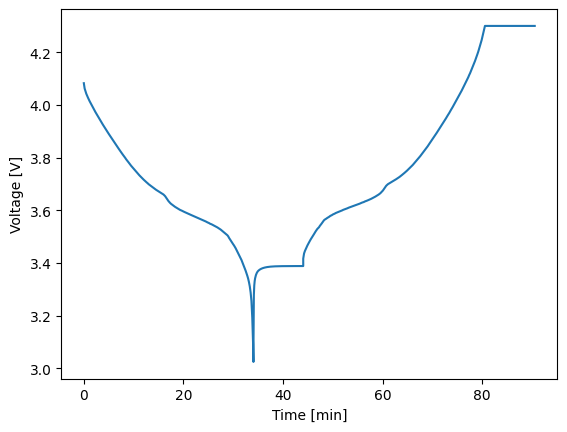

In [12]:
combined_soln.simple_plot('time_min', 'voltage_V')